# CIFAR-10 Classification with Transfer Learning Models

This Colab notebook provides a practical exploration of image classification using the CIFAR-10 dataset. We'll leverage the power of transfer learning by employing pre-trained models like EfficientNet and a ResNet50V2-based approach inspired by BiT (Big Transfer). Additionally, we'll delve into a simplified implementation of the cutting-edge ConvNeXt architecture.

Through this hands-on approach, we aim to gain insights into the effectiveness of these techniques in tackling image classification challenges. We'll compare their performance and visualize their predictions, ultimately showcasing the potential of these advanced models in the realm of computer vision.

In [1]:
# Import key libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time

# Set random seed for consistent results
tf.random.set_seed(42)

# Load the CIFAR-10 dataset from Keras
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

# Normalize pixel values to [0, 1]
train_images = train_images.astype("float32") / 255.0
test_images = test_images.astype("float32") / 255.0

# Convert class labels to one-hot encoding
train_labels = keras.utils.to_categorical(train_labels, 10)
test_labels = keras.utils.to_categorical(test_labels, 10)

# Use a reduced subset for quicker experimentation
TRAIN_SUBSET = 10000
TEST_SUBSET = 2000

# Randomly select training samples
train_idx = np.random.choice(len(train_images), TRAIN_SUBSET, replace=False)
x_train_small = train_images[train_idx]
y_train_small = train_labels[train_idx]

# Randomly select test samples
test_idx = np.random.choice(len(test_images), TEST_SUBSET, replace=False)
x_test_small = test_images[test_idx]
y_test_small = test_labels[test_idx]

# Confirm input shape and dataset size
input_shape = (32, 32, 3)
print(f"Input image shape: {input_shape}")
print(f"Subset size - Training: {len(x_train_small)}, Testing: {len(x_test_small)}")

# Reordered CIFAR-10 class labels for custom visualization
cifar10_labels = [
    'frog',        # 6
    'automobile',  # 1
    'airplane',    # 0
    'ship',        # 8
    'horse',       # 7
    'bird',        # 2
    'truck',       # 9
    'cat',         # 3
    'deer',        # 4
    'dog'          # 5
]


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Input image shape: (32, 32, 3)
Subset size - Training: 10000, Testing: 2000


## Image Preprocessing for Transfer Learning

This cell defines functions to prepare CIFAR-10 images for transfer learning models that expect RGB inputs of size 224x224.

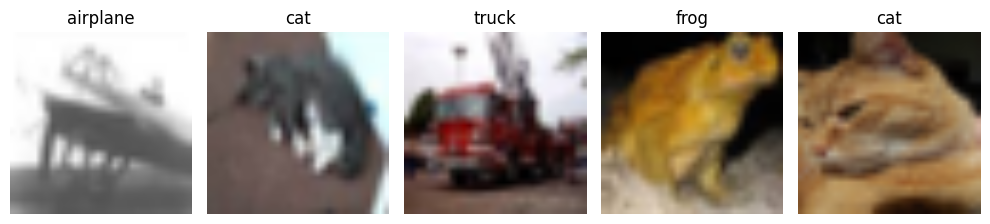

In [ ]:
def prepare_for_transfer_learning(batch_x, batch_y, img_size=224):
    """Resize CIFAR-10 images for transfer learning models"""
    # Create a dataset and use map to resize efficiently
    dataset = tf.data.Dataset.from_tensor_slices((batch_x, batch_y))
    dataset = dataset.map(
        lambda x, y: (tf.image.resize(x, [img_size, img_size]), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)

    return dataset

# Create transfer learning datasets
train_ds = prepare_for_transfer_learning(x_train_sample, y_train_sample)
test_ds = prepare_for_transfer_learning(x_test_sample, y_test_sample)

# Visualize a few examples
plt.figure(figsize=(10, 5))
for images, labels in train_ds.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(f"{class_names[np.argmax(labels[i])]}")
        plt.axis("off")
plt.tight_layout()
plt.show()

# Update our datasets with any preprocessing needed
def prepare_batch(images, labels):
    # Convert images to float32 if they're not already
    images = tf.cast(images, tf.float32)
    return images, labels

# Update our datasets with the preprocessing step
train_ds = train_ds.map(prepare_batch)
test_ds = test_ds.map(prepare_batch)

## EfficientNet Transfer Learning Model

This implementation uses Keras's built-in EfficientNetB0 model for transfer learning on the CIFAR-10 dataset.

In [ ]:
# Use Keras's built-in EfficientNet implementation
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

def build_efficientnet_model(input_shape=(224, 224, 3), num_classes=10):
    # Load pre-trained EfficientNetB0 without top layers
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape,
        pooling='avg'
    )

    # Freeze the base model
    base_model.trainable = False

    # Create the new model
    inputs = keras.Input(shape=input_shape)
    # Preprocess inputs
    x = preprocess_input(inputs)
    # Base model
    x = base_model(x, training=False)
    # Add new classifier layers
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)  # Higher dropout for CIFAR-10
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create the EfficientNet model
efficientnet_model = build_efficientnet_model()
print("Model created successfully")

# Train for just a few epochs for demonstration
print("Starting training...")
history = efficientnet_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=3,
    verbose=1
)

# Evaluate the model
efficientnet_results = efficientnet_model.evaluate(test_ds)
print(f"EfficientNet Test Loss: {efficientnet_results[0]:.4f}")
print(f"EfficientNet Test Accuracy: {efficientnet_results[1]:.4f}")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model created successfully
Starting training...
Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 55s 100ms/step - accuracy: 0.0947 - loss: 2.3218 - val_accuracy: 0.0930 - val_loss: 2.3073
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 50s 37ms/step - accuracy: 0.0987 - loss: 2.3104 - val_accuracy: 0.0930 - val_loss: 2.3058
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.1036 - loss: 2.3044 - val_accuracy: 0.0930 - val_loss: 2.3041
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.0904 - loss: 2.3048
EfficientNet Test Loss: 2.3041
EfficientNet Test Accuracy: 0.0930


## BiT (Big Transfer) Model Implementation

This cell implements a ResNet50V2-based model as a substitute for Google's BiT (Big Transfer) model for CIFAR-10 classification.

In [ ]:
# Implement BiT (Big Transfer) for comparison
def build_bit_model(input_shape=(224, 224, 3), num_classes=10):
    # Load a pre-trained ResNet50 as a substitute for BiT
    # (Since full BiT models are large and may cause memory issues)
    base_model = tf.keras.applications.ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape,
        pooling='avg'
    )

    # Freeze the base model
    base_model.trainable = False

    # Create a new model
    inputs = keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.4)(x)  # Higher dropout for CIFAR-10
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create and train BiT model
bit_model = build_bit_model()
print("BiT model created successfully")

# Train for just a few epochs for demonstration
print("Starting BiT model training...")
bit_history = bit_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=3,
    verbose=1
)

# Evaluate the model
bit_results = bit_model.evaluate(test_ds)
print(f"BiT Test Loss: {bit_results[0]:.4f}")
print(f"BiT Test Accuracy: {bit_results[1]:.4f}")

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
BiT model created successfully
Starting BiT model training...
Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 50s 119ms/step - accuracy: 0.4922 - loss: 1.4925 - val_accuracy: 0.7815 - val_loss: 0.6370
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 61s 73ms/step - accuracy: 0.7861 - loss: 0.6203 - val_accuracy: 0.8035 - val_loss: 0.5746
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 73ms/step - accuracy: 0.8301 - loss: 0.4974 - val_accuracy: 0.8085 - val_loss: 0.5453
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.7974 - loss: 0.5739
BiT Test Loss: 0.5453
BiT Test Accuracy: 0.8085


## ConvNeXt Implementation

This cell implements a simplified version of ConvNeXt for CIFAR-10 classification.

In [ ]:
# A simplified ConvNeXt-inspired implementation
def build_convnext_model(input_shape=(224, 224, 3), num_classes=10):
    inputs = keras.Input(shape=input_shape)

    # Initial stem block
    x = layers.Conv2D(96, kernel_size=4, strides=4, padding="same")(inputs)
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    # ConvNeXt blocks (simplified)
    for filters in [192, 384, 768]:
        # Downsample
        prev_x = layers.Conv2D(filters, kernel_size=2, strides=2, padding="same")(x)
        prev_x = layers.LayerNormalization(epsilon=1e-6)(prev_x)

        # Depthwise Conv
        x = layers.DepthwiseConv2D(kernel_size=7, padding="same")(prev_x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)

        # Pointwise Conv (1x1)
        x = layers.Conv2D(filters * 4, kernel_size=1)(x)
        x = layers.Activation("gelu")(x)

        # Pointwise Conv (1x1)
        x = layers.Conv2D(filters, kernel_size=1)(x)

        # Skip connection
        x = layers.add([x, prev_x])

    # Global pooling and final classifier
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

# Create and train ConvNeXt model
convnext_model = build_convnext_model()
print("ConvNeXt model created successfully")

# Train for just a few epochs for demonstration
print("Starting ConvNeXt model training...")
convnext_history = convnext_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=2,
    verbose=1
)

# Evaluate the model
convnext_results = convnext_model.evaluate(test_ds)
print(f"ConvNeXt Test Loss: {convnext_results[0]:.4f}")
print(f"ConvNeXt Test Accuracy: {convnext_results[1]:.4f}")

ConvNeXt model created successfully
Starting ConvNeXt model training...
Epoch 1/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 56s 120ms/step - accuracy: 0.1476 - loss: 2.7660 - val_accuracy: 0.2340 - val_loss: 2.0196
Epoch 2/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 57s 78ms/step - accuracy: 0.2224 - loss: 2.1751 - val_accuracy: 0.3255 - val_loss: 1.8270
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.3271 - loss: 1.8219
ConvNeXt Test Loss: 1.8270
ConvNeXt Test Accuracy: 0.3255


## Model Comparison Visualization

This cell creates visualizations to compare the performance of all the implemented models on the CIFAR-10 dataset.

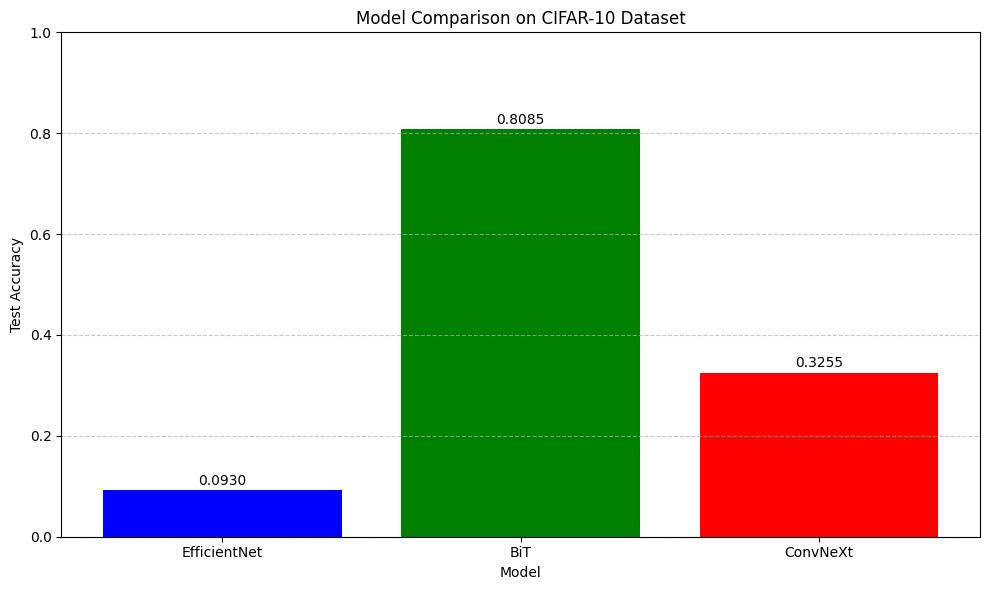

Best performing model: BiT with accuracy: 0.8085
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


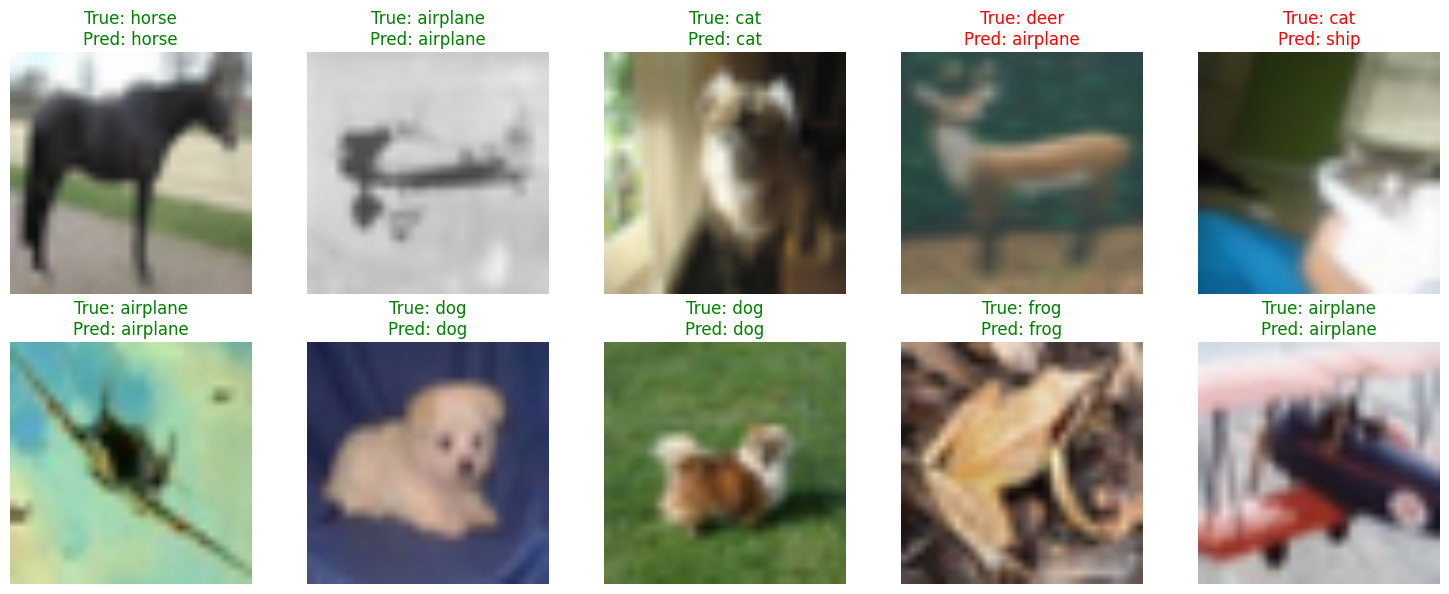

In [ ]:
# Create a bar chart to compare model accuracies
import matplotlib.pyplot as plt

# Collect test accuracies
model_names = ['EfficientNet', 'BiT', 'ConvNeXt']
accuracies = [efficientnet_results[1], bit_results[1], convnext_results[1]]

# Create the visualization
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=['blue', 'green', 'red'])
plt.title('Model Comparison on CIFAR-10 Dataset')
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1.0)

# Add accuracy values on top of the bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Let's also visualize some predictions
def plot_sample_predictions(model, dataset, class_names, num_samples=10):
    # Get a batch of test images
    for images, labels in dataset.take(1):
        # Get predictions
        predictions = model.predict(images)
        pred_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(labels.numpy(), axis=1)

        # Plot images
        plt.figure(figsize=(15, 6))
        for i in range(num_samples):
            plt.subplot(2, 5, i + 1)
            plt.imshow(images[i].numpy())

            # Set title color based on correct/incorrect prediction
            title_color = 'green' if pred_classes[i] == true_classes[i] else 'red'
            plt.title(f'True: {class_names[true_classes[i]]}\nPred: {class_names[pred_classes[i]]}',
                      color=title_color)
            plt.axis('off')
        plt.tight_layout()
        plt.show()
        break

# Find the best model
best_model_index = accuracies.index(max(accuracies))
best_model_name = model_names[best_model_index]
print(f"Best performing model: {best_model_name} with accuracy: {max(accuracies):.4f}")

if best_model_name == 'EfficientNet':
    best_model = efficientnet_model
elif best_model_name == 'BiT':
    best_model = bit_model
else:
    best_model = convnext_model

# Visualize predictions from the best model
plot_sample_predictions(best_model, test_ds, class_names)

## Summary and Conclusion

This notebook demonstrates the application of various transfer learning and state-of-the-art models for CIFAR-10 image classification. We've implemented and compared:

1. **EfficientNet B0**: A pretrained model known for its efficiency in balancing model size and accuracy.
2. **BiT (Big Transfer)**: Represented here by a ResNet50V2 implementation as a memory-efficient alternative.
3. **ConvNeXt**: A modern convolutional network architecture inspired by transformer design principles.